In [20]:
# --- plotting + display niceties ---
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# slightly nicer matplotlib defaults
mpl.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 12
})

from ACM_irt import fit_2pl, irt_prob, total_loglik, initialisation, update_theta, rescale_theta_and_items, update_items

df1 = pd.read_csv("IRTMatrix.csv")
df2 = pd.read_csv("IRTMatrixExtended.csv")
df1 = df1.iloc[:, 1:].copy()
df2 = df2.iloc[:, 1:].copy()
df2

,L1_A1,L1_A2,L1_A3,L2_A1,L2_A2,L2_A3,L3_A1,L3_A2,L3_A3,L4_A1,...,L18_A3,L19_A1,L19_A2,L19_A3,L20_A1,L20_A2,L20_A3,L21_A1,L21_A2,L21_A3
0,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,0,1,1
4,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
697,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
698,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
699,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
700,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


,n_person,n_item,missing_rate
0,702,21,0.0


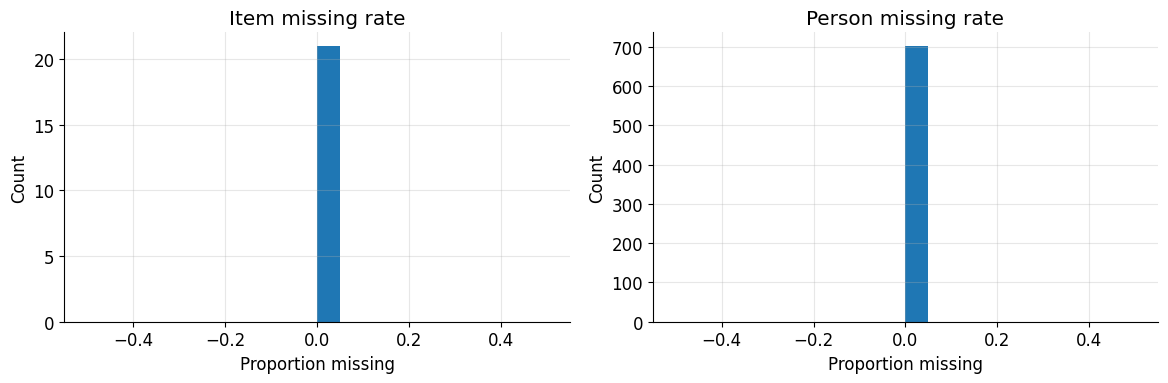

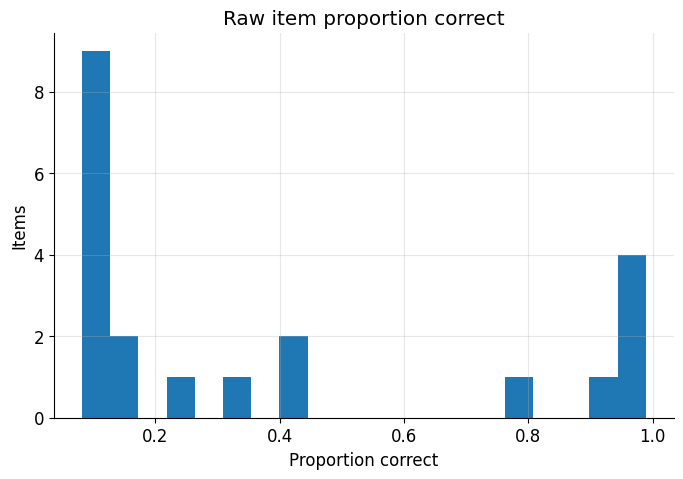

In [12]:
n_person, n_item = df1.shape
display(pd.DataFrame({
    "n_person": [n_person],
    "n_item": [n_item],
    "missing_rate": [df1.isna().mean().mean()]
}))

# per-item and per-person missingness
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(df1.isna().mean(0), bins=20)
ax[0].set(title="Item missing rate", xlabel="Proportion missing", ylabel="Count")
ax[1].hist(df1.isna().mean(1), bins=20)
ax[1].set(title="Person missing rate", xlabel="Proportion missing", ylabel="Count")
plt.tight_layout()
plt.show()

# item difficulty proxy from raw data (proportion correct)
item_p = df1.mean(0, skipna=True)
plt.figure()
plt.hist(item_p, bins=20)
plt.title("Raw item proportion correct")
plt.xlabel("Proportion correct")
plt.ylabel("Items")
plt.show()


In [15]:
fit = fit_2pl(
    df1,
    max_iters=200,
    tol=1e-4,
    theta_inner=10,
    item_inner=25,
    l2=1e-6,
    verbose=True
)



[init]   loglik = -3815.432998
[iter 01] loglik = -1770.924812  Δrel = 5.359e-01
[iter 02] loglik = -1661.944332  Δrel = 6.154e-02
[iter 03] loglik = -1821.337432  Δrel = -9.591e-02
Converged at iter 3 (Δrel=-9.591e-02 < 0.0001).


In [16]:
theta = fit["theta"]
a = fit["a"]
b = fit["b"]

print("Converged:", fit["converged"])
print("Iterations:", fit["n_iter"])
print("\nItem discrimination (a):", a[:5])
print("Item difficulty (b):", b[:5])
print("Ability (theta):", theta[:5])


Converged: True
Iterations: 3

Item discrimination (a): [2.54053972 1.6397459  2.94966598 4.99382955 7.72886141]
Item difficulty (b): [-1.9429614  -3.37818224 -2.00918805 -1.1719145  -0.90877947]
Ability (theta): [ 0.04733104  0.69398754 -0.30324626  0.8384912   0.04733104]


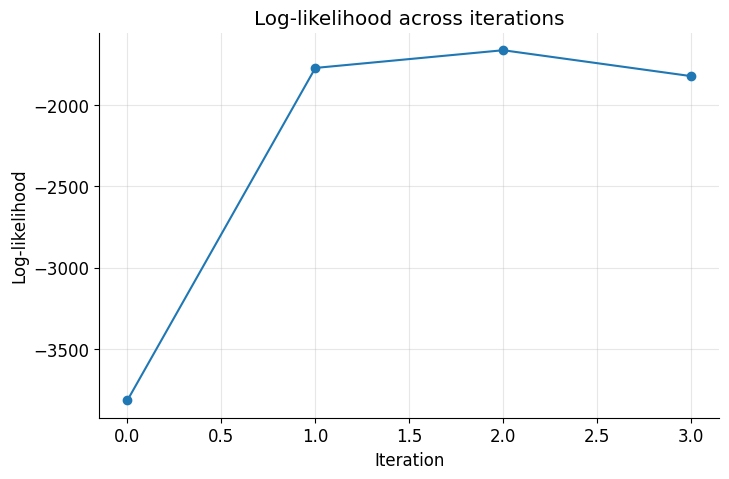

In [17]:
plt.figure()
plt.plot(fit["history"], marker="o")
plt.title("Log-likelihood across iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.show()


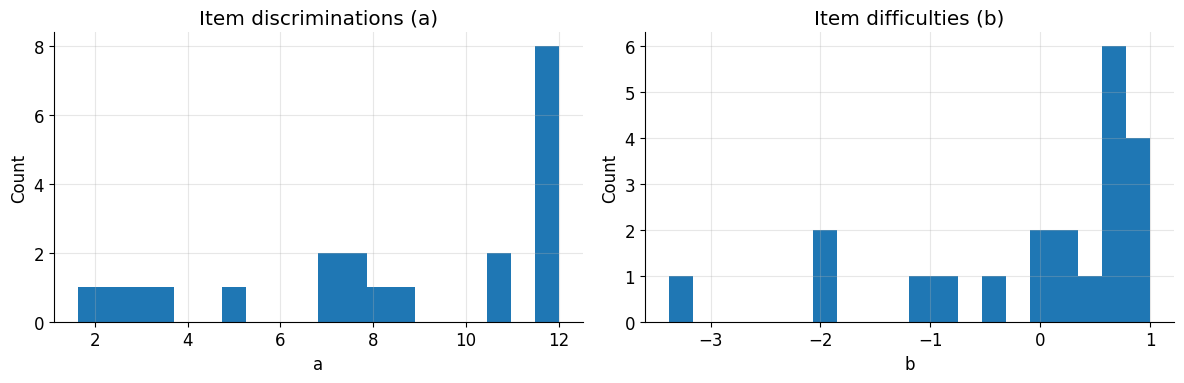

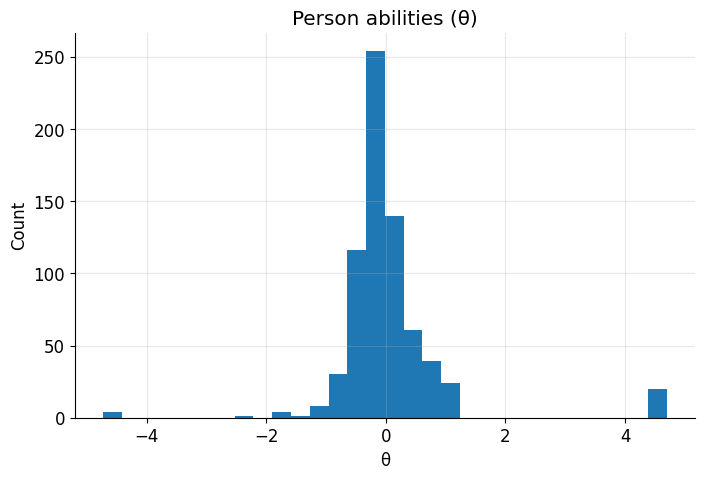

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(a, bins=20)
ax[0].set(title="Item discriminations (a)", xlabel="a", ylabel="Count")
ax[1].hist(b, bins=20)
ax[1].set(title="Item difficulties (b)", xlabel="b", ylabel="Count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(theta, bins=30)
plt.title("Person abilities (θ)")
plt.xlabel("θ")
plt.ylabel("Count")
plt.show()


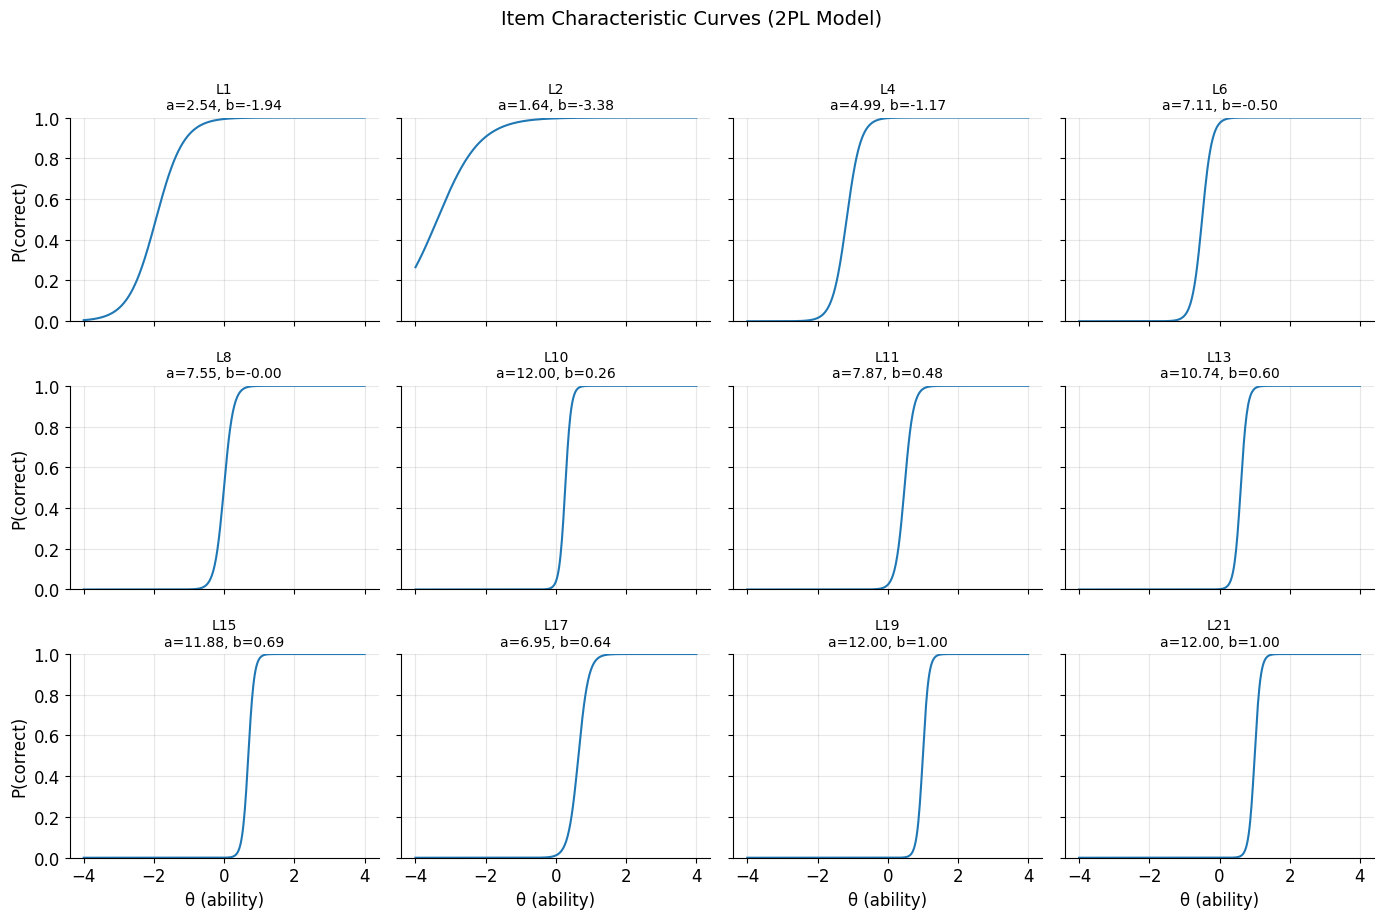

In [19]:
def plot_icc_grid(a, b, item_names=None, n_cols=4, n_items=12, theta_min=-4, theta_max=4):
    """
    Plot a grid of item characteristic curves for selected items.
    """
    idx = np.linspace(0, len(a)-1, num=min(n_items, len(a)), dtype=int)
    tgrid = np.linspace(theta_min, theta_max, 400)
    n_rows = int(np.ceil(len(idx) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5*n_cols, 3*n_rows), sharex=True, sharey=True)
    axes = np.atleast_1d(axes).ravel()

    for k, j in enumerate(idx):
        p = 1 / (1 + np.exp(-a[j]*(tgrid - b[j])))
        ax = axes[k]
        ax.plot(tgrid, p, color="C0")
        name = item_names[j] if item_names is not None else f"Item {j+1}"
        ax.set_title(f"{name}\na={a[j]:.2f}, b={b[j]:.2f}", fontsize=10)
        ax.set_ylim(0,1)
        ax.grid(True, alpha=0.3)

    for ax in axes[len(idx):]:
        ax.axis("off")

    fig.suptitle("Item Characteristic Curves (2PL Model)", y=1.02, fontsize=14)
    for ax in axes[-n_cols:]:
        ax.set_xlabel("θ (ability)")
    for r in range(n_rows):
        axes[r*n_cols].set_ylabel("P(correct)")
    plt.tight_layout()
    plt.show()

# Run the plot
plot_icc_grid(a, b, item_names=df1.columns.to_numpy(), n_cols=4, n_items=12)


[init]   loglik = -3815.432998
[iter 01] loglik = -1770.924812  Δrel = 5.359e-01
[iter 02] loglik = -1661.944332  Δrel = 6.154e-02
[iter 03] loglik = -1821.337432  Δrel = -9.591e-02
Converged at iter 3 (Δrel=-9.591e-02 < 0.0001).


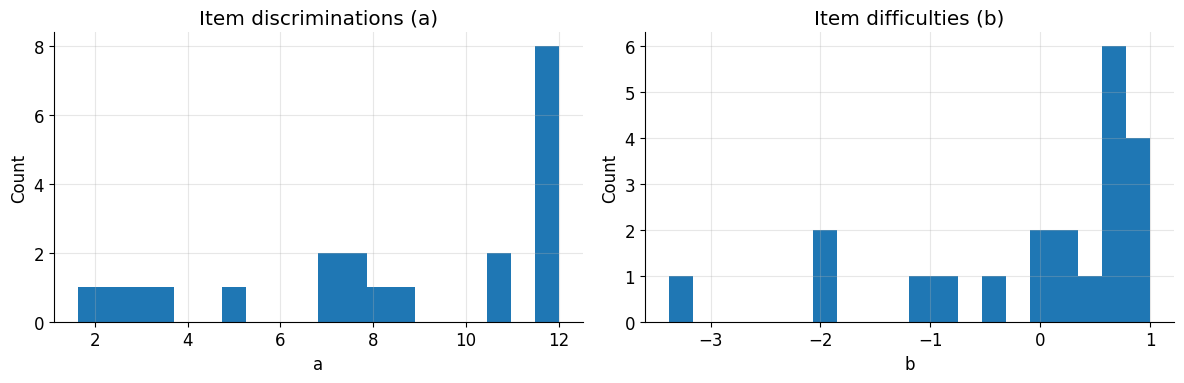

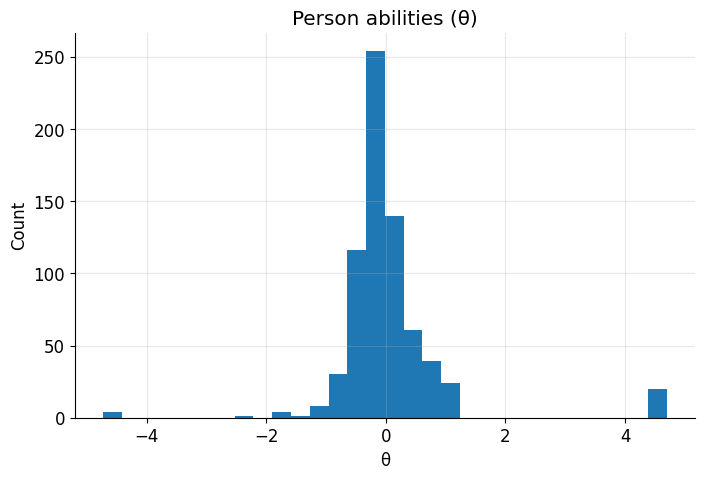

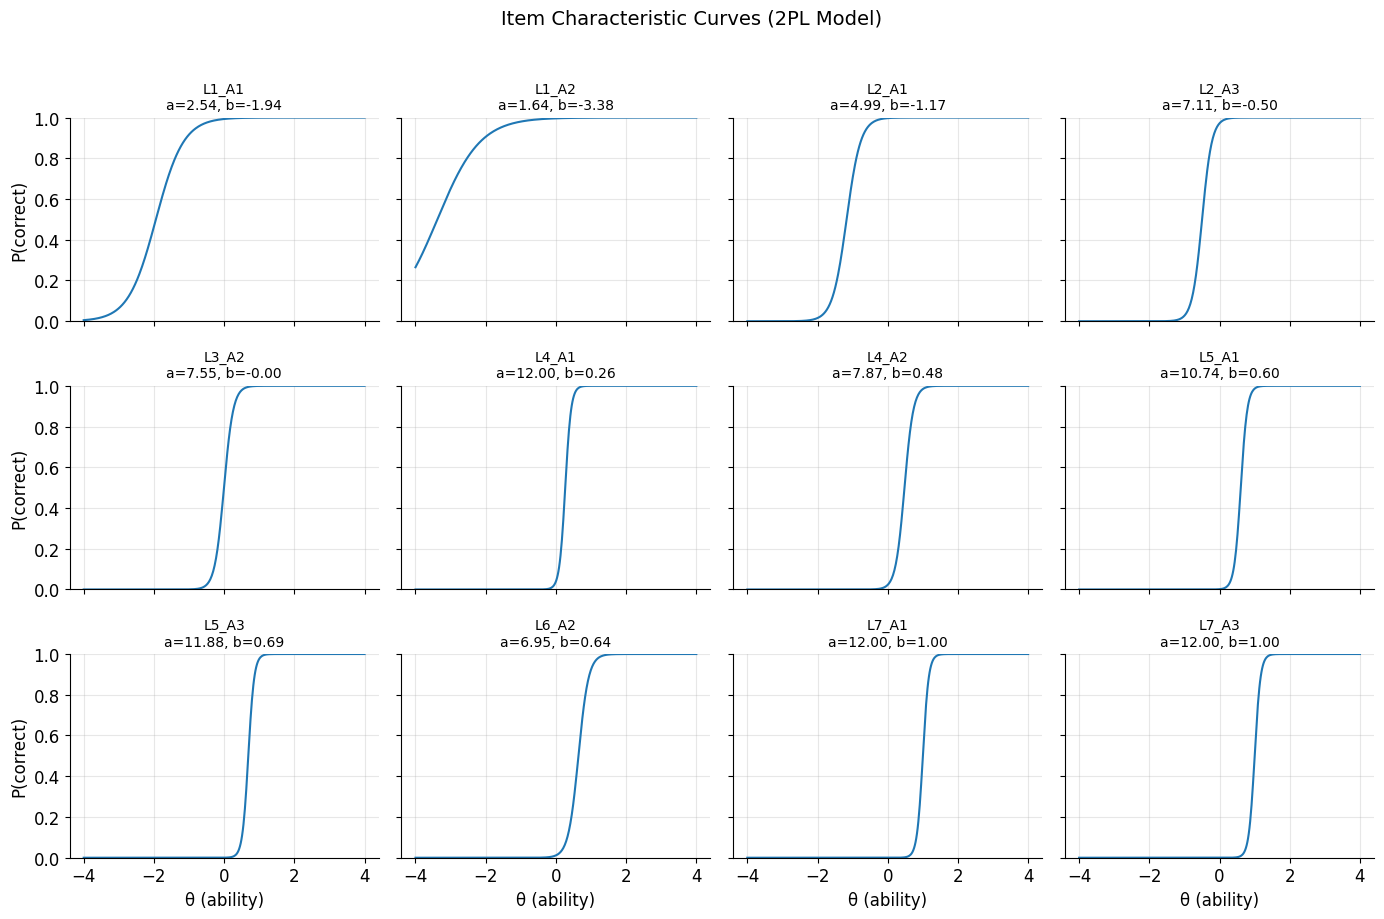

In [21]:
fit = fit_2pl(
    df1,
    max_iters=200,
    tol=1e-4,
    theta_inner=10,
    item_inner=25,
    l2=1e-6,
    verbose=True
)

theta = fit["theta"]
a = fit["a"]
b = fit["b"]

fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(a, bins=20)
ax[0].set(title="Item discriminations (a)", xlabel="a", ylabel="Count")
ax[1].hist(b, bins=20)
ax[1].set(title="Item difficulties (b)", xlabel="b", ylabel="Count")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(theta, bins=30)
plt.title("Person abilities (θ)")
plt.xlabel("θ")
plt.ylabel("Count")
plt.show()

plot_icc_grid(a, b, item_names=df2.columns.to_numpy(), n_cols=4, n_items=12)